# Аппроксимация данных 
***

In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0])
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4])

w = torch.ones(())
b = torch.zeros(())

В этой главе мы несколько изменим архитектуру модели: для решения нашей
задачи преобразования температуры реализуем полноценную искусственную
нейронную сеть. Мы будем и в дальнейшем использовать цикл обучения из
прошлой главы, а также разбиение нашего набора примеров преобразования
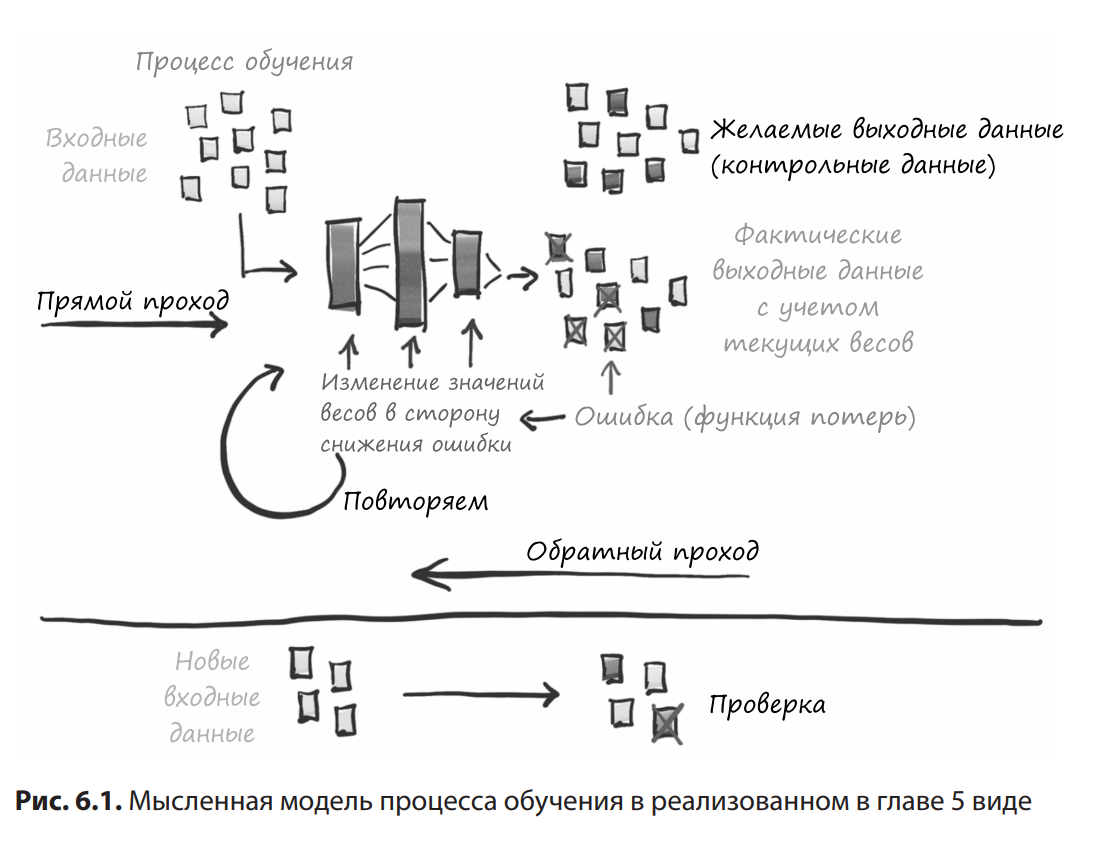

Фаренгейт — Цельсий на обучающий и проверочный наборы. Мы могли бы
перейти к использованию квадратичной модели: переписать model в виде квадратичной функции входного сигнала **(например, y = a * x в степени 2 + b * x + c)**. В силу
дифференцируемости подобной модели PyTorch позаботился бы о вычислении
градиентов, и цикл обучения работал бы как обычно. Интересного в таком варианте, впрочем, для нас немного, ведь мы при этом по-прежнему зафиксировали
бы форму функции


В этой главе мы начнем связывать воедино все результаты подготовительной
работы и возможности PyTorch, которые вам предстоит использовать каждый
божий день при работе над своими проектами. Вы узнаете, что происходит под
крышкой «черного ящика» APIPyTorch. Прежде чемзаняться реализацией нашей
новой модели, обсудим, что имеется в виду под искусственной нейронной сетью

# Функция ошибки

Важное различие между предыдущей нашей линейной моделью и той, которую
мы будем использовать для глубокого обучения, — форма функции ошибки. 
Наша линейная модель и функция потерь на основе квадрата ошибки обладали
выпуклой кривой ошибки с одним четко определенным минимумом. 


При использовании других методов можно было искать параметры, автоматически
и однозначно минимизирующие функции ошибки. Это значит, что наши
обновления параметров пытались оценить этот один правильный ответ как
можно точнее

## Сжатие выходного диапазона
***

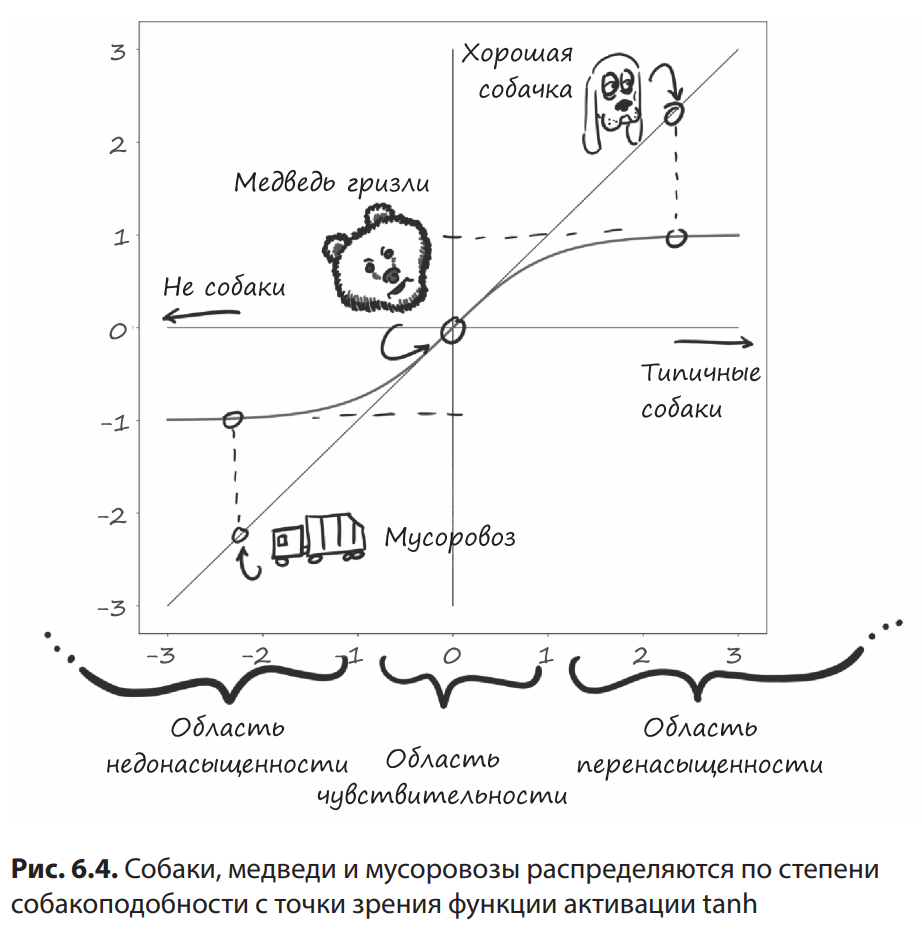

В результате мусоровозы помечаются как «не собаки», наша хорошая собачка
оказывается «явно собакой», а медведь оказывается примерно посередине. 
Конкретные значения можно увидеть в коде:

In [3]:
import math

print(math.tanh(-2.2), "- Мусоровоз")
print(math.tanh(0.1), "- Медведь")
print(math.tanh(2.5), "- Хорошая собачка")

-0.9757431300314515 - Мусоровоз
0.09966799462495582 - Медведь
0.9866142981514303 - Хорошая собачка


Поскольку медведь находится в диапазоне чувствительности, его небольшие
изменения приведут к заметным изменениям результатов. Например, если мы
возьмем вместо гризли полярного медведя (у которого несколько более собакоподобная морда), то увидим скачок по оси Y при перемещении в сторону
«типичная собака» на графике. И наоборот, коалу модель сочтет менее похожим на собаку, и можно будет наблюдать падение активированного выходного
сигнала. Мусоровоз, впрочем, вряд ли можно сделать более похожим на собаку, даже при самых коренных изменениях, выходной сигнал изменится лишь
с –0,97 до 0,8 или около того

## Другие функции активации
***

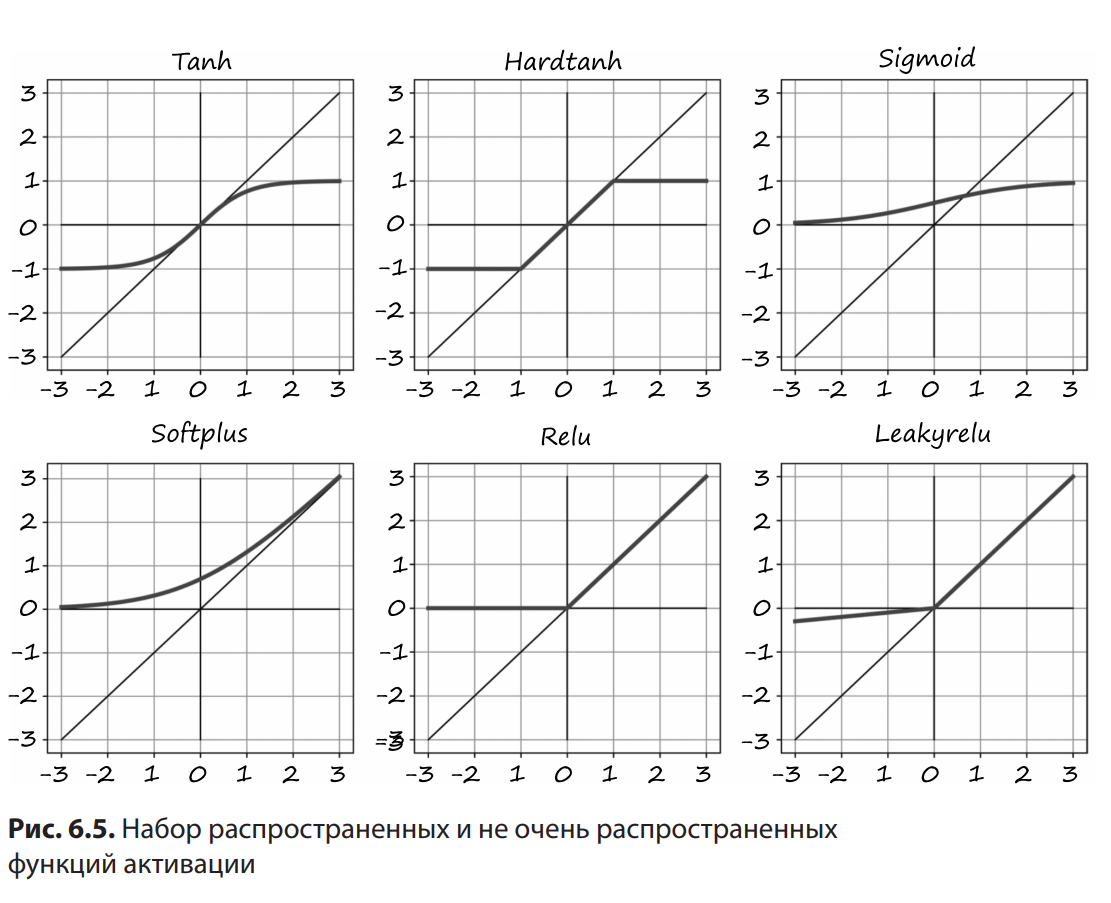

## Выбор наилучшей функции активации
***

Несмотря на наличие такого широкого спектра прекрасно работающих функций активации (намного большего, чем показано на рис. 6.5), они интересны
практически полным отсутствием жестких требований. Тем не менее функции
активации по определению1

* нелинейны — сколько ни применяй преобразование вида (w*x+b) без функции активации, все равно получится функция той же самой (аффинной линейной) формы. Нелинейность позволяет сети в целом аппроксимировать более сложные функции.

* дифференцируемы, что дает возможность вычисления градиентов. Точечные разрывы, как мы увидим в Hardtanh и ReLU, допустимы

# Модуль nn PyTorch
***

В PyTorch есть отдельный подмодуль, посвященный нейронным сетям, —
torch.nn. Он включает «кирпичики», необходимые для создания всех видов
нейросетевых архитектур. В терминологии PyTorch эти «кирпичики» называются
модулями (в других фреймворках подобные стандартные блоки часто называются
слоями (layers)). Модуль PyTorch — это класс Python, наследующий базовый
класс nn.Module. Атрибутами модуля PyTorch могут быть один или несколько
экземпляров класса Parameter — тензоров, значения которых проходят оптимизацию во время процесса обучения (аналогично w и b в нашей линейной модели). У модуля может быть также один или несколько подмодулей (подклассов
nn.Module) в качестве атрибутов, и он сможет отслеживать также и их параметры.

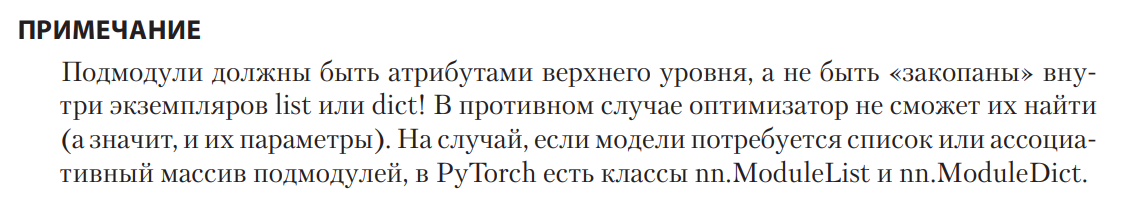

## Использование метода __call__  вместо метода forward
У всех подклассов nn.Module в PyTorch есть метод __call__, позволяющий создавать экземпляры nn.Linear и вызывать их как функции следующим образом:

In [4]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn

In [5]:
""" Входные данные """
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # Добавляем еще одно измерение на оси 1
t_u = torch.tensor(t_u).unsqueeze(1) # Добавляем еще одно измерение на оси 1


t_u.shape

torch.Size([11, 1])

In [6]:
t_u

tensor([[35.7000],
        [55.9000],
        [58.2000],
        [81.9000],
        [56.3000],
        [48.9000],
        [33.9000],
        [21.8000],
        [48.4000],
        [60.4000],
        [68.4000]])

In [7]:
""" Разбивка на train/valid """
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples) # 20% на валидацию

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 1,  5, 10,  6,  7,  0,  9,  3,  4]), tensor([2, 8]))

In [8]:
""" Делим на трейн и валид """
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [9]:
t_un_val

tensor([[5.8200],
        [4.8400]])

In [10]:
linear_model = nn.Linear(1, 1)# Мы обсудим аргументы конструктора в ближайшее время
linear_model(t_un_val)

tensor([[-1.6112],
        [-1.4671]], grad_fn=<AddmmBackward0>)

Вызов экземпляра nn.Module с набором инструментов приводит к вызову метода
forward с теми же аргументами, который реализует прямой проход вычислений,
в то время как __call__ выполняет другие немаловажные операции до и после
вызова forward. Так что формально можно вызвать forward напрямую, и он
вернет тот же результат, что и __call__, но делать это из пользовательского
кода не рекомендуется:

In [11]:
linear_model.weight

Parameter containing:
tensor([[-0.1470]], requires_grad=True)

In [12]:
linear_model.bias

Parameter containing:
tensor([-0.7557], requires_grad=True)

In [13]:
x = torch.ones(1)
linear_model(x)

tensor([-0.9027], grad_fn=<AddBackward0>)

In [14]:
x = torch.ones(10, 1) # подача батча
linear_model(x)

tensor([[-0.9027],
        [-0.9027],
        [-0.9027],
        [-0.9027],
        [-0.9027],
        [-0.9027],
        [-0.9027],
        [-0.9027],
        [-0.9027],
        [-0.9027]], grad_fn=<AddmmBackward0>)

In [15]:
linear_model = nn.Linear(1, 1) # Просто переопределение
optimizer = optim.SGD(
    linear_model.parameters(), # Этот вызов метода — вместо [params]
    lr=1e-2)

In [16]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.2441]], requires_grad=True),
 Parameter containing:
 tensor([0.6680], requires_grad=True)]

Этот вызов рекурсивно заходит в подмодули, указанные в конструкторе init
модуля, и возвращает плоский список всех найденных параметров, благодаря чему
можно удобно передать его конструктору оптимизатора, как мы и сделали ранее

Мы можем уже заняться циклом обучения. Оптимизатору передается список
тензоров, описанных с **requires_grad = True** — все объекты Parameter описываются подобным образом по определению, поскольку их необходимо оптимизировать путем градиентного спуска. При вызове метода **training_loss.backward()**
в листьях графа вычислений накапливаются градиенты. Это как раз и есть
передаваемые оптимизатору параметры

Теперь у оптимизатора SGD есть все необходимое. При вызове **optimizer.step()**
программа проходит по всем объектам Parameter и меняет их на соответствующую содержимому атрибута grad долю. Прекрасная архитектура.

In [17]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # вместо отдельных параметров передается модель
        loss_train = loss_fn(t_p_train, t_c_train)
        
        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

Остался еще один, последний элемент torch.nn, которым мы можем воспользоваться: функция потерь. Разумеется, nn включает несколько распространенных
функций потерь, одна из которых — nn.MSELoss, ее мы раньше описали в качестве
нашей loss_fn. Функции потерь в nn — тоже подклассы nn.Module, так что мы
создадим еще один экземпляр и вызовем его как функцию. В нашем случае мы
заменяем самодельную loss_fn

In [18]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000,
    optimizer= optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # Мы больше не используем нашу рукописную функцию потерь
    t_u_train= t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val
)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 107.5194, Validation loss 55.2398
Epoch 1000, Training loss 3.1787, Validation loss 5.6793
Epoch 2000, Training loss 2.6255, Validation loss 4.6883
Epoch 3000, Training loss 2.6159, Validation loss 4.5653

Parameter containing:
tensor([[5.3054]], requires_grad=True)
Parameter containing:
tensor([-16.8012], requires_grad=True)


# Наконец-то нейронная сеть
***
## Замена линейной модели

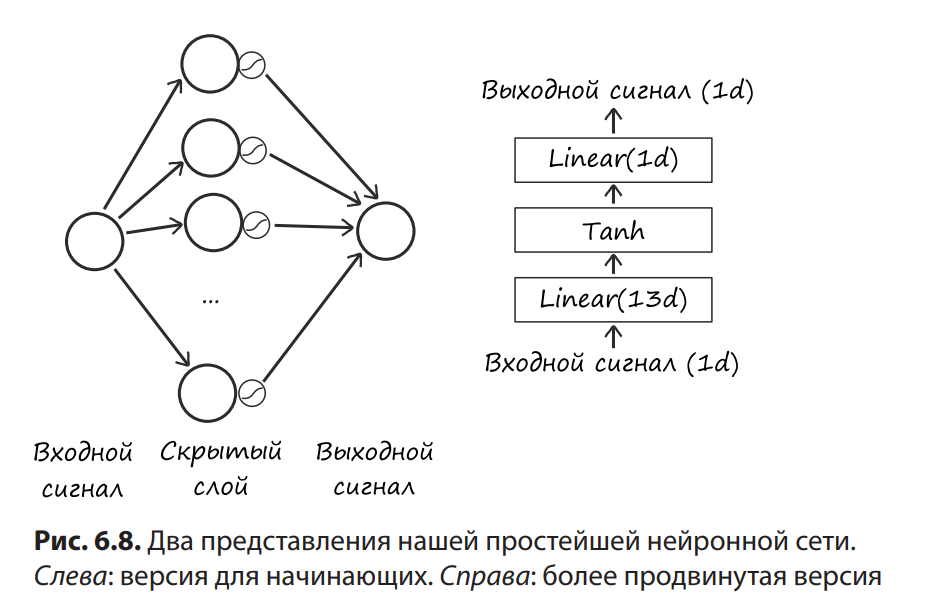

Модуль nn предоставляет удобный способ соединения модулей цепочкой с помощью контейнера nn.Sequential:

In [19]:
seq_model = nn.Sequential(
                nn.Linear(1, 2),
                nn.Tanh(),
                nn.Linear(2, 1))
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=2, bias=True)
  (1): Tanh()
  (2): Linear(in_features=2, out_features=1, bias=True)
)

Модель переходит от одного входного признака до
13 скрытых признаков, пропускает их через функцию активации Tanh и, наконец,
объединяет получившиеся 13 чисел в один выходной признак

## Просматриваем информацию о параметрах

При вызове model.parameters() собираются weight и bias как из первого, так
и из второго линейного модуля. В данном случае будет поучительно изучить
параметры, отобразив на экран информацию об их форме

In [20]:
[param.shape for param in seq_model.parameters()]

[torch.Size([2, 1]), torch.Size([2]), torch.Size([1, 2]), torch.Size([1])]

Эти тензоры и получит оптимизатор. Опять же, после вызова model.backward()
все параметры заполняются grad, а затем оптимизатор обновляет их значения соответствующим образом во время вызова optimizer.step(). Не так уж
сильно отличается от нашей предыдущей модели, правда? В конце концов,
они обе — дифференцируемые модели, обучаемые посредством градиентного
спуска.

Несколько замечаний относительно параметров nn.Module. При просмотре
информации о параметрах модели, состоящей из нескольких модулей, не помешает возможность идентифицировать параметры по названию. Для этой цели
предназначен метод **named_parameters**

In [21]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([2, 1])
0.bias torch.Size([2])
2.weight torch.Size([1, 2])
2.bias torch.Size([1])


Названия модулей в Sequential представляют собой просто порядковые номера
модулей в списке аргументов. Что любопытно, Sequential1 также принимает на
входе OrderedDict, в котором можно указать название каждого из передаваемых
Sequential модулей:

In [22]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ("hidden_linear", nn.Linear(1, 8)),
    ("hidden_activation", nn.Tanh()),
    ("output_linear", nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

Это дает возможность дать подмодулям более понятные названия:

In [23]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


Намного информативнее; но нам еще нужно добиться большей гибкости процесса движения данных по сети, который пока что остается чисто последовательным — название nn.Sequential говорит само за себя. В главе 8 мы обсудим,
как получить полный контроль над обработкой входных данных путем создания
подкласса nn.Module.

Обращаться к конкретным объектам **Parameter** можно путем указания подмодулей в качестве атрибутов:

In [24]:
seq_model.output_linear.bias

Parameter containing:
tensor([-0.0824], requires_grad=True)

Это очень удобно для просмотра параметров или их градиентов, например для
мониторинга градиентов во время обучения, какмы делали в начале данной главы. 
Допустим, мы хотели бы вывести на экран градиенты параметра weight линейной
части скрытого слоя. Запускаемцикл обучения для новоймодели нейронной сети,
после чего смотрим на получившиеся градиенты после последней эпохи

In [25]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs=5000,
    optimizer=optimizer,
    model=seq_model,
    loss_fn=nn.MSELoss(),
    t_u_train=t_un_train,
    t_u_val=t_un_val,
    t_c_train=t_c_train,
    t_c_val=t_c_val
)

Epoch 1, Training loss 205.7404, Validation loss 136.7321
Epoch 1000, Training loss 4.8712, Validation loss 3.5009
Epoch 2000, Training loss 3.6760, Validation loss 4.1023
Epoch 3000, Training loss 1.9911, Validation loss 2.2883
Epoch 4000, Training loss 1.6722, Validation loss 2.6069
Epoch 5000, Training loss 1.6315, Validation loss 2.7831


## Сравнение с линейной моделью

In [26]:
from matplotlib import pyplot as plt

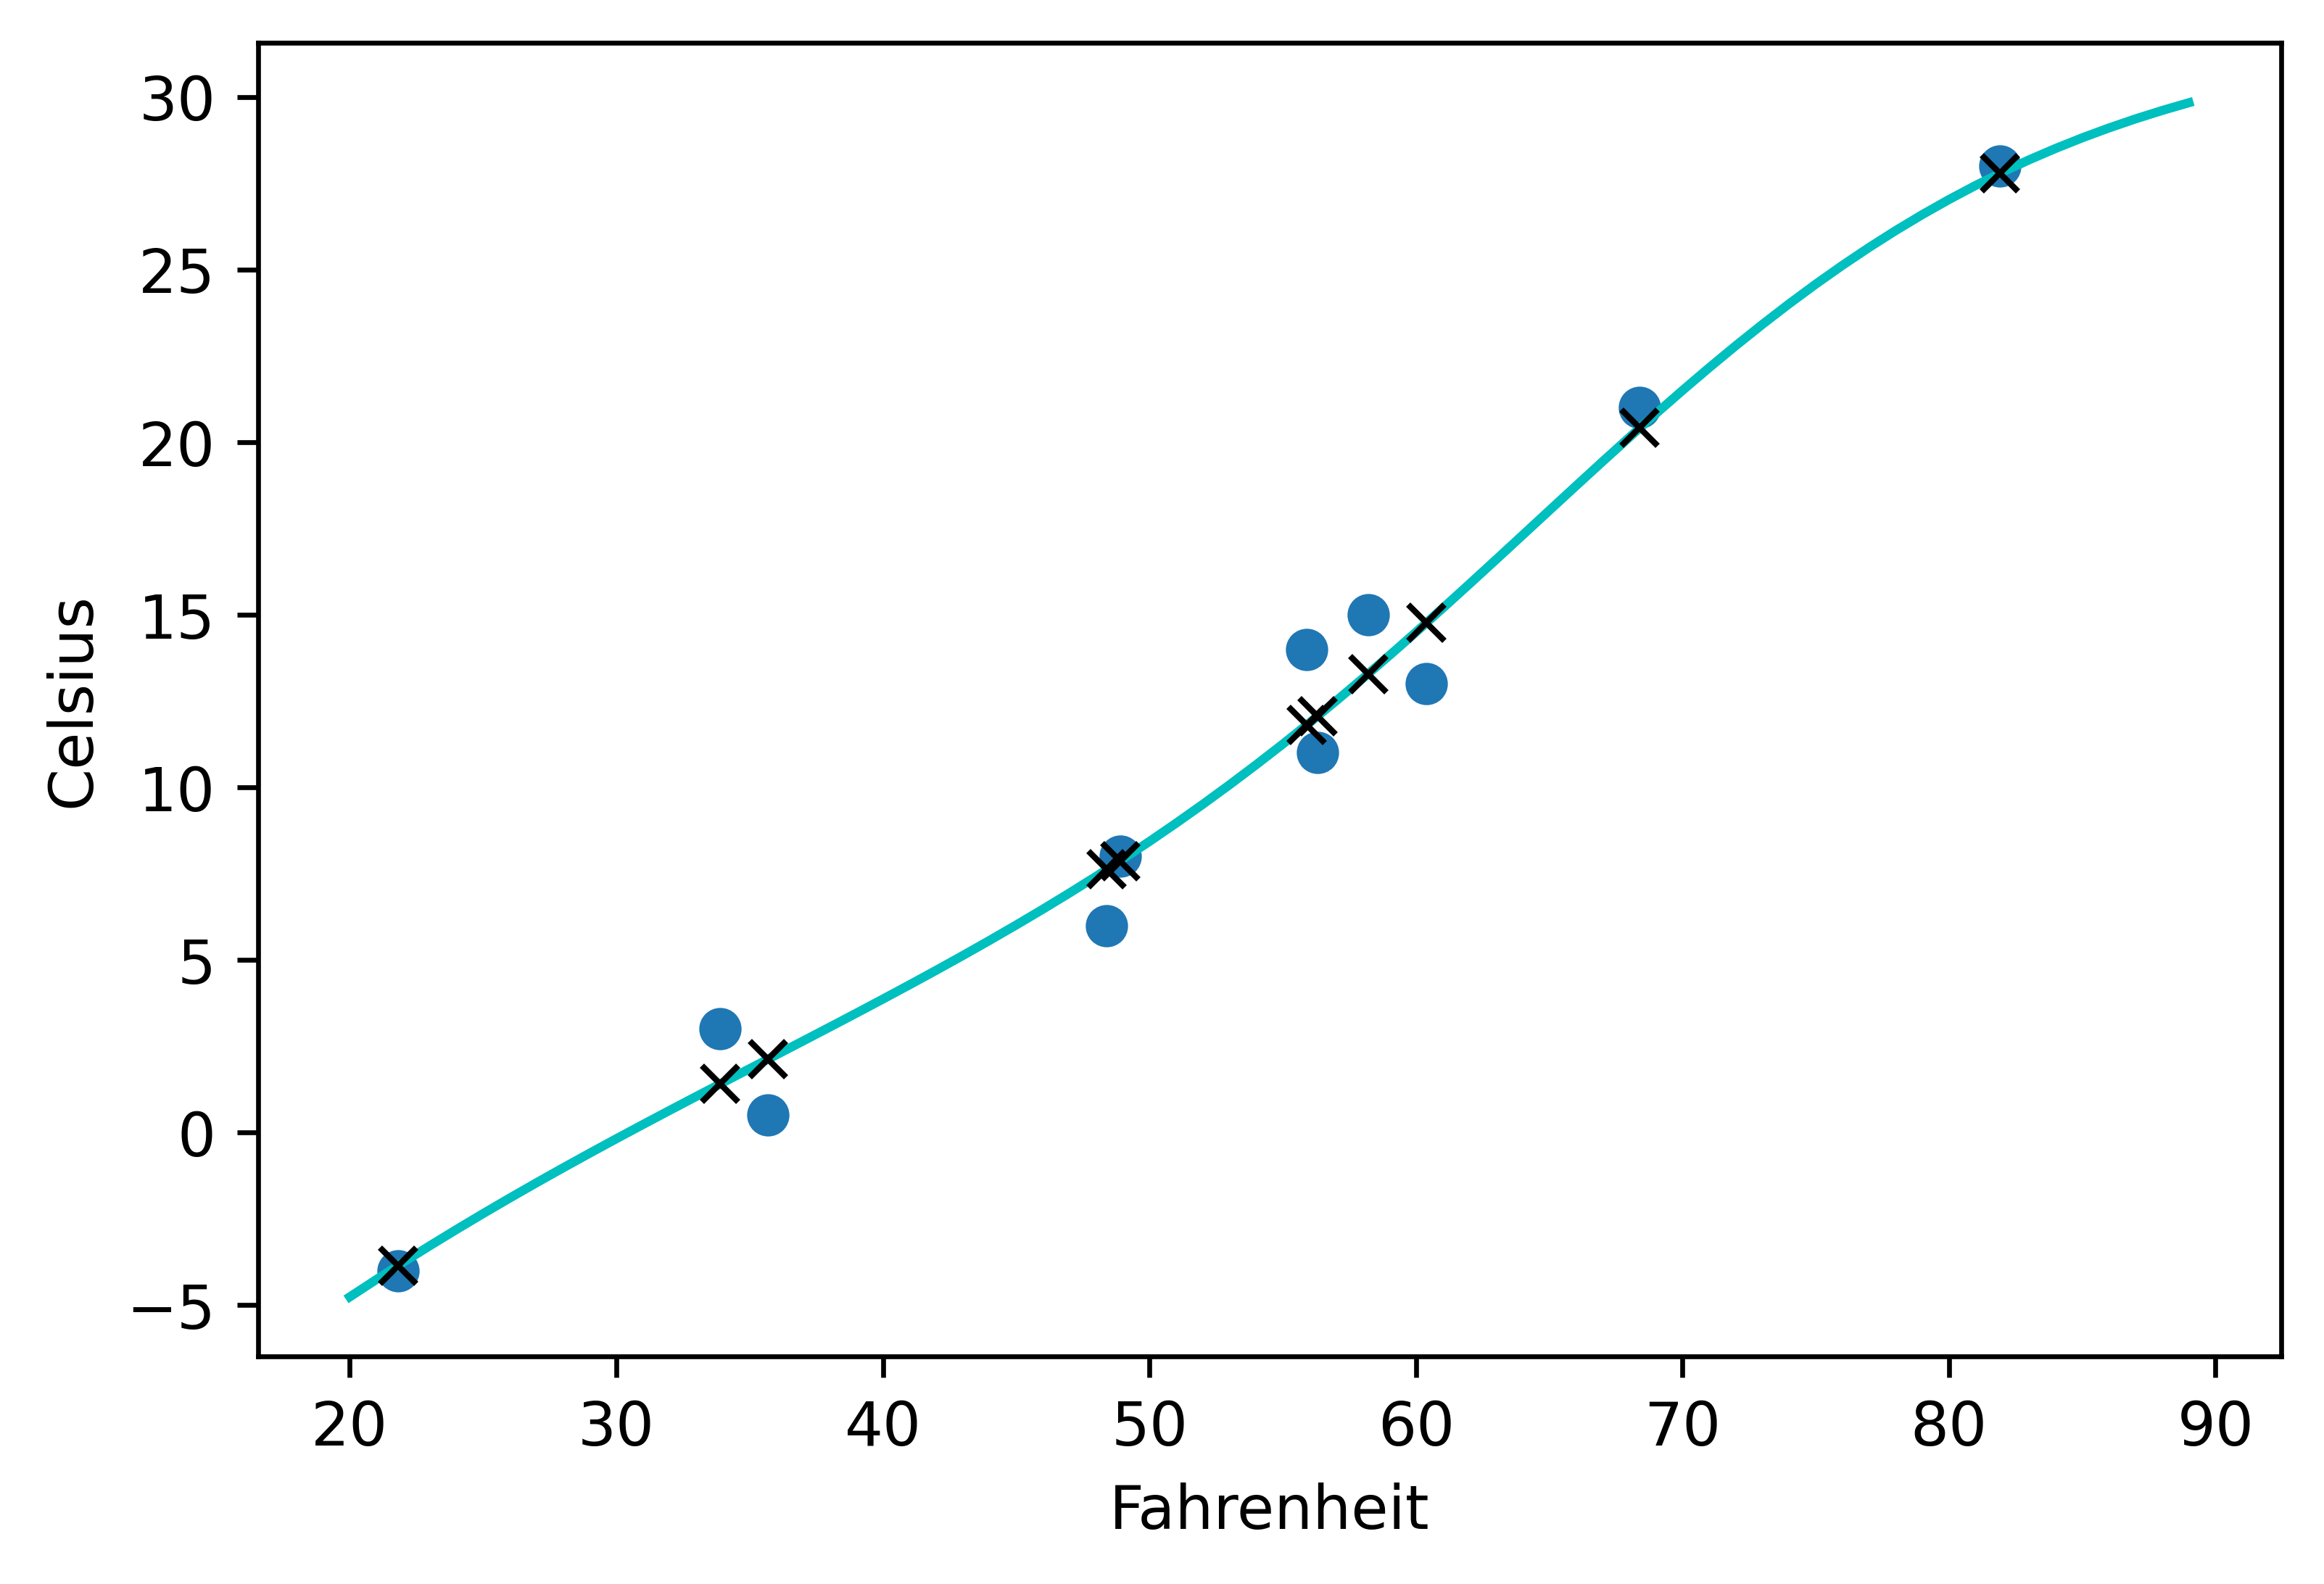

In [27]:
t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), "o")
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), "c-")
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), "kx")

График нейросетевой модели со входными данными (кружки) и выходным 
сигналом модели (X). Непрерывная кривая отражает поведение модели 
в промежутках между примерами данных

# Попробуем на винах

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
RND = 21

In [29]:
data = pd.read_csv("./winequality-white.csv", sep=';')
print(data)

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.0              0.27         0.36            20.7      0.045   
1               6.3              0.30         0.34             1.6      0.049   
2               8.1              0.28         0.40             6.9      0.050   
3               7.2              0.23         0.32             8.5      0.058   
4               7.2              0.23         0.32             8.5      0.058   
...             ...               ...          ...             ...        ...   
4893            6.2              0.21         0.29             1.6      0.039   
4894            6.6              0.32         0.36             8.0      0.047   
4895            6.5              0.24         0.19             1.2      0.041   
4896            5.5              0.29         0.30             1.1      0.022   
4897            6.0              0.21         0.38             0.8      0.020   

      free sulfur dioxide  

In [30]:
x = data.drop("quality", axis=1)
y = data["quality"]

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


Пропусков нету, ЗАМЕЧАТЕЛЬНО, двигаем дальше

In [32]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [33]:
X_train, X_test, y_train, y_test = train_test_split(x,y ,
                                   random_state=RND, 
                                   test_size=0.25, 
                                   shuffle=True)

In [34]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ("hidden_linear", nn.Linear(11, 20)),
    ("hidden_activation", nn.Tanh()),
    ("output_linear", nn.Linear(20, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=11, out_features=20, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=20, out_features=1, bias=True)
)

In [35]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # вместо отдельных параметров передается модель
        loss_train = loss_fn(t_p_train, t_c_train)
        
        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        if epoch == 1 or epoch % 1 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

In [36]:
optimizer = optim.SGD(seq_model.parameters(), lr=0.005)

training_loop(
    n_epochs=200,
    optimizer=optimizer,
    model=seq_model,
    loss_fn=nn.MSELoss(),
    t_u_train=torch.tensor(X_train.values).float(),
    t_u_val=torch.tensor(X_test.values).float(),
    t_c_train=torch.tensor(y_train.values).float(),
    t_c_val=torch.tensor(y_test.values).float()
)

Epoch 1, Training loss 30.0663, Validation loss 30.3002


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([3673])) that is different to the input size (torch.Size([3673, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([1225])) that is different to the input size (torch.Size([1225, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2, Training loss 17.5558, Validation loss 17.7177
Epoch 3, Training loss 11.2620, Validation loss 11.3809
Epoch 4, Training loss 7.3315, Validation loss 7.4171
Epoch 5, Training loss 4.8770, Validation loss 4.9365
Epoch 6, Training loss 3.3443, Validation loss 3.3834
Epoch 7, Training loss 2.3871, Validation loss 2.4103
Epoch 8, Training loss 1.7895, Validation loss 1.8001
Epoch 9, Training loss 1.4162, Validation loss 1.4171
Epoch 10, Training loss 1.1832, Validation loss 1.1763
Epoch 11, Training loss 1.0377, Validation loss 1.0247
Epoch 12, Training loss 0.9468, Validation loss 0.9290
Epoch 13, Training loss 0.8900, Validation loss 0.8685
Epoch 14, Training loss 0.8546, Validation loss 0.8300
Epoch 15, Training loss 0.8325, Validation loss 0.8056
Epoch 16, Training loss 0.8187, Validation loss 0.7899
Epoch 17, Training loss 0.8100, Validation loss 0.7798
Epoch 18, Training loss 0.8046, Validation loss 0.7732
Epoch 19, Training loss 0.8012, Validation loss 0.7689
Epoch 20, Trai

Epoch 153, Training loss 0.7947, Validation loss 0.7598
Epoch 154, Training loss 0.7947, Validation loss 0.7598
Epoch 155, Training loss 0.7947, Validation loss 0.7598
Epoch 156, Training loss 0.7947, Validation loss 0.7598
Epoch 157, Training loss 0.7947, Validation loss 0.7598
Epoch 158, Training loss 0.7947, Validation loss 0.7598
Epoch 159, Training loss 0.7946, Validation loss 0.7598
Epoch 160, Training loss 0.7946, Validation loss 0.7598
Epoch 161, Training loss 0.7946, Validation loss 0.7598
Epoch 162, Training loss 0.7946, Validation loss 0.7598
Epoch 163, Training loss 0.7946, Validation loss 0.7598
Epoch 164, Training loss 0.7946, Validation loss 0.7598
Epoch 165, Training loss 0.7946, Validation loss 0.7598
Epoch 166, Training loss 0.7946, Validation loss 0.7598
Epoch 167, Training loss 0.7946, Validation loss 0.7598
Epoch 168, Training loss 0.7946, Validation loss 0.7598
Epoch 169, Training loss 0.7946, Validation loss 0.7598
Epoch 170, Training loss 0.7946, Validation loss